  # Chamber Analysis

In this example we'll start to look at the aerosols in a smog chamber with a focus on how the size distributions evolves with time. The example data is from a NaCl aerosol experiment in a smog chamber (900 L).

The Experiment:

After injection of NaCl particles, the chamber was only slowly purged with clean air, so the aerosols would be pushed out to the instruments. The clean air flow was 1.25 LPM (1 SLPM). No chemistry was happening in the chamber, so the aerosol size distribution should be stable from a condensation point of view. The aerosol distribution should change due to coagulation and wall losses.

Let's start by loading the data and plotting the size distribution.

In [1]:
# all the imports
import numpy as np
import matplotlib.pyplot as plt
from particula.data import loader_interface, settings_generator
from particula.data.tests.example_data.get_example_data import get_data_folder

from particula.data import stream_stats
from particula.util import convert, time_manage
# set the parent directory of the data folders
path = get_data_folder()
print('Path to data folder:')
print(path.rsplit('particula')[-1])

Path to data folder:
\data\tests\example_data


 ### Load the data
 We'll uses the settings from the Data loading examples, to load the Scanning Mobility Particle Sizer (SMPS) data.

In [2]:
# load the 1d data
smps_1d_stream_settings = settings_generator.load_settings_for_stream(
    path=path,
    subfolder='chamber_data',
    settings_suffix='_smps_1d',
)
stream_smps_1d = loader_interface.load_files_interface(
    path=path,
    settings=smps_1d_stream_settings
)

# load the 2d data
smps_2d_stream_settings = settings_generator.load_settings_for_stream(
    path=path,
    subfolder='chamber_data',
    settings_suffix='_smps_2d',
)
stream_smps_2d = loader_interface.load_files_interface(
    path=path,
    settings=smps_2d_stream_settings
)

print(stream_smps_1d.header)

  Loading file: 2023-09-25_160155_SMPS.csv
  Loading file: 2023-09-25_160155_SMPS.csv
['Lower_Size_(nm)', 'Upper_Size_(nm)', 'Sample_Temp_(C)', 'Sample_Pressure_(kPa)', 'Relative_Humidity_(%)', 'Median_(nm)', 'Mean_(nm)', 'Geo_Mean_(nm)', 'Mode_(nm)', 'Geo_Std_Dev.', 'Total_Conc_(#/cc)']


## Pause to Plot
Let's pause to plot the data. We'll plot the size distribution at the start and end of the experiment.

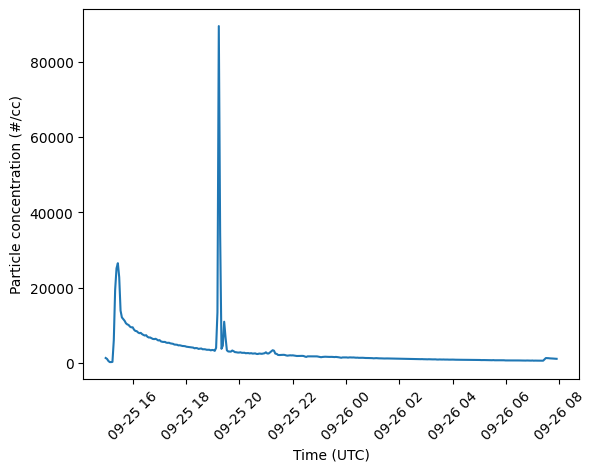

In [3]:
# plot the 1d data
fig, ax = plt.subplots()
ax.plot(
    stream_smps_1d.datetime64,
    stream_smps_1d['Total_Conc_(#/cc)'],
    label='Concentration'
)
plt.xticks(rotation=45)
ax.set_xlabel("Time (UTC)")
ax.set_ylabel('Particle concentration (#/cc)')
plt.show()
fig.tight_layout()

## Clean up the data

Now their are a couple things we need to account for from the raw data.

1. The SMPS data is in dN/dlogDp, but we want dN/dDp. So we need to convert the data.
2. The SMPS sample line was diluted 1:2 with clean air, so we need to account for that.
3. Then we need to remove those couple scans where data jumps crazy high (due to a cpc malfunction), around 1900.
4. We need to select from after the injection starts and before the chamber is purged (that small bump at the end of the data).

In [4]:
# 1 convert to dn/dDp
stream_smps_2d.data = convert.convert_sizer_dn(
    diameter=np.array(stream_smps_2d.header, dtype=float),
    dn_dlogdp=stream_smps_2d.data,
)

# Dilution correction
dilution_correction = 2

# scale the concentrations
stream_smps_2d.data *= dilution_correction
stream_smps_1d['Total_Conc_(#/cc)'] *= dilution_correction

## Plot the distributions

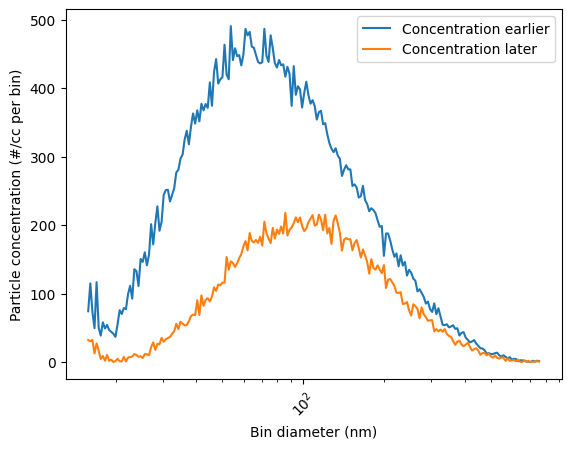

In [6]:
# plot the 2d data
fig, ax = plt.subplots()
ax.plot(
    stream_smps_2d.header_float,
    stream_smps_2d.data[10, :],
    label='Concentration earlier'
)
ax.plot(
    stream_smps_2d.header_float,
    stream_smps_2d.data[20, :],
    label='Concentration later'
)
ax.set_xscale('log')
plt.xticks(rotation=45)
ax.set_xlabel("Bin diameter (nm)")
ax.set_ylabel('Particle concentration (#/cc per bin)')
plt.legend()
plt.show()
fig.tight_layout()

## 3. Remove the Bad data points

To we'll send the select start and end times to `particula.data.stream_stats.remove_time_window` to remove the data in that time window.


Length of stream before crop: 336
Length of stream after crop: 321


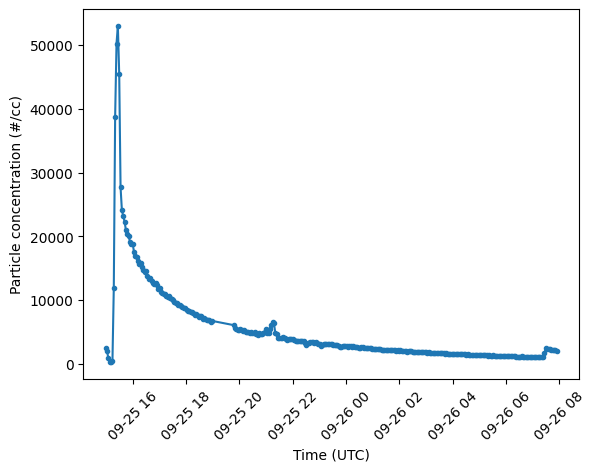

In [7]:

# select the time window
bad_window_start_epoch = time_manage.time_str_to_epoch(
    time='09-25-2023 19:00:00',
    time_format='%m-%d-%Y %H:%M:%S',
    timezone_identifier='UTC'
)
bad_window_end_epoch = time_manage.time_str_to_epoch(
    time='09-25-2023 19:45:00',
    time_format='%m-%d-%Y %H:%M:%S',
    timezone_identifier='UTC'
)

print(f"Length of stream before crop: {len(stream_smps_1d)}")
# remove the bad data
stream_smps_1d = stream_stats.remove_time_window(
    stream=stream_smps_1d,
    epoch_start=bad_window_start_epoch,
    epoch_end=bad_window_end_epoch,
)
print(f"Length of stream after crop: {len(stream_smps_1d)}")
# plot the 1d data
fig, ax = plt.subplots()
ax.plot(
    stream_smps_1d.datetime64,
    stream_smps_1d['Total_Conc_(#/cc)'],
    label='Concentration',
    marker='.',
)
plt.xticks(rotation=45)
ax.set_xlabel("Time (UTC)")
ax.set_ylabel('Particle concentration (#/cc)')
plt.show()

In [8]:
### Repeat the removal for the 2d data

stream_smps_2d = stream_stats.remove_time_window(
    stream=stream_smps_2d,
    epoch_start=bad_window_start_epoch,
    epoch_end=bad_window_end_epoch,
)

## 4. Crop to the Start and End of the Experiment

To crop the start and end we can use the same functions as in the previous example. This time the start/end will just be the first and last time in the data.

In [9]:
# crop start
experiment_start_epoch = time_manage.time_str_to_epoch(
    time='09-25-2023 15:25:00',
    time_format='%m-%d-%Y %H:%M:%S',
    timezone_identifier='UTC'
)

stream_smps_1d = stream_stats.remove_time_window(
    stream=stream_smps_1d,
    epoch_start=stream_smps_1d.time[0],
    epoch_end=experiment_start_epoch,
)
stream_smps_2d = stream_stats.remove_time_window(
    stream=stream_smps_2d,
    epoch_start=stream_smps_2d.time[0],
    epoch_end=experiment_start_epoch,
)

# crop the end
experiment_end_epoch = time_manage.time_str_to_epoch(
    time='09-26-2023 07:00:00',
    time_format='%m-%d-%Y %H:%M:%S',
    timezone_identifier='UTC'
)

stream_smps_1d = stream_stats.remove_time_window(
    stream=stream_smps_1d,
    epoch_start=experiment_end_epoch,
    epoch_end=stream_smps_1d.time[-1],
)
stream_smps_2d = stream_stats.remove_time_window(
    stream=stream_smps_2d,
    epoch_start=experiment_end_epoch,
    epoch_end=stream_smps_2d.time[-1],
)

### Plot the Cleaned Data

Here, we'll also conver to relative time, so hours since the start of the experiment.

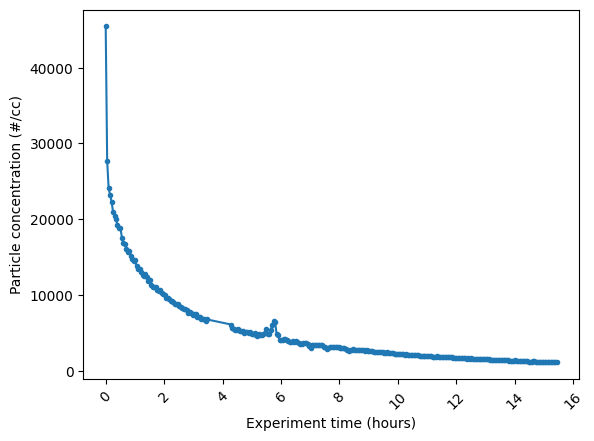

In [10]:
# plot the 1d data
experiment_time = time_manage.relative_time(
    epoch_array=stream_smps_1d.time,
    units='hours',
)

fig, ax = plt.subplots()
ax.plot(
    experiment_time,
    stream_smps_1d['Total_Conc_(#/cc)'],
    label='Concentration',
    marker='.',
)
plt.xticks(rotation=45)
ax.set_xlabel("Experiment time (hours)")
ax.set_ylabel('Particle concentration (#/cc)')
plt.show()

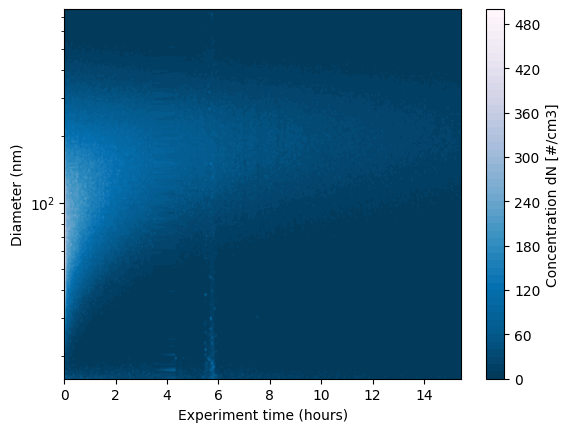

In [12]:
# Plot the 2d data

fig, ax = plt.subplots(1, 1)
plt.contourf(
    experiment_time,
    stream_smps_2d.header_float,
    stream_smps_2d.data.T,
    cmap=plt.cm.PuBu_r, levels=50)
plt.yscale('log')
ax.set_xlabel('Experiment time (hours)')
ax.set_ylabel('Diameter (nm)')
plt.colorbar(label='Concentration dN [#/cm3]', ax=ax)
plt.show()


# Summary

We've now loaded the data, cleaned it up, and plotted the size distribution. We can see that the size distribution is changing with time. We'll look at accounting for chamber processes, like coagulation, dilution, and wall losses, in the next part.